# Calculation for EAPE in calculation of total eddy energy to compare to low-order model

\begin{equation} \frac{dE}{dt} = \mathcal X E  \end{equation}
\begin{equation}  \rightarrow E = e^{\pm i \omega t} \text{    where   } \omega = \sqrt{ab/2} \end{equation}

In [9]:
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=26) #20 
rc('ytick', labelsize=26) #20
rc('axes', titlesize=26)    # fontsize of the axes title
rc('axes', labelsize=26) #24  
rc('font', **{'size':26})
import matplotlib.pyplot as plt

In [1]:
import xarray as xr
import netCDF4 as nc

In [2]:
from dask.distributed import Client

c=Client(local_directory = '/scratch/e14/qo9901/') 
c 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45681 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45681/status,
Dashboard: /proxy/45681/status,Workers: 4
Total threads: 4,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37059,Workers: 4
Dashboard: /proxy/45681/status,Total threads: 4
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:32779,Total threads: 1
Dashboard: /proxy/43643/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:33563,


In [3]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:32779': 56,
 'tcp://127.0.0.1:34325': 56,
 'tcp://127.0.0.1:40397': 56,
 'tcp://127.0.0.1:41203': 56}

## Calculating Available potential energy 

$ APE  = \int^{L_y}_0 \frac{1}{2}\rho_0 g' \eta^2 \, \mathrm{d}y $

where $\eta$ is the interface height that varies in the two layer system. Now we want:

$ APE  = \sum_i \int^{L_y}_0 \frac{1}{2}\rho_0 g' \eta_i^2 \, \mathrm{d}y $

 summing over layer interfaces i
 
 Selecting only the CDW layer, we measure eta relative to the sponged interface height of CDw on the northern boundary. Here we take a deepening of the isopycnal relative to the sponged interface height as an increase in eta, as the increase in potential energy occur when the isopycnal is deepened relative to the sponged interface.

In [14]:
folder = '/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02/'
t1 = 51
t2 = 71
FileList = [folder + 'output' + '{0:03}'.format(i) + '/prog_daily.nc' for i in range(t1 ,t2)]
dsx_prog_daily = xr.open_mfdataset(FileList, combine='by_coords', chunks={"Time": 20}, decode_times=False, preprocess = lambda d: d[['e', 'h','uh','vh']], engine='netcdf4', parallel=True)
dsx_prog_daily.coords['Time'] = dsx_prog_daily.coords['Time']/(365)
import xgcm
grid = xr.open_mfdataset(folder+'output0*/ocean_geometry.nc', combine='by_coords')
grid_new = grid.rename({'latq': 'yq','lonq': 'xq','lath': 'yh','lonh': 'xh'})
ds = xr.merge([dsx_prog_daily.uh, dsx_prog_daily.vh, grid_new])

## making grid
ds.coords['xh'].attrs.update(axis='X')
ds.coords['xq'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yh'].attrs.update(axis='Y')
ds.coords['yq'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])
grid

### making APE values
#H  = dsx_prog_daily.e.sel(yh = slice(-50,100)).mean(dim = 'Time')
eta = (dsx_prog_daily.e.sel(yh = slice(-50,100)))#.isel(zi = slice(1,5))
print(eta)
eta_0 = -dsx_prog_daily.e.isel(zi=2).sel(yh = 250, method = 'nearest').mean(dim = ['xh','Time'])

print(eta_0.values)
eta_calc = (- eta.isel(zi=2).sel(yh = slice(-20,100)) - eta_0)
#eta_calc = (eta_0 + eta.sel(yh = slice(-50,100)))

print(eta_calc)

<xarray.DataArray 'e' (Time: 7300, zi: 5, yh: 150, xh: 1000)>
dask.array<getitem, shape=(7300, 5, 150, 1000), dtype=float32, chunksize=(20, 5, 150, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -49.5 -48.5 -47.5 -46.5 -45.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time) float64 51.0 51.0 51.01 51.01 ... 70.99 70.99 71.0 71.0
  * xh       (xh) float64 -499.5 -498.5 -497.5 -496.5 ... 497.5 498.5 499.5
  * zi       (zi) float64 1.028e+03 1.028e+03 1.028e+03 1.028e+03 1.028e+03
Attributes:
    units:          m
    long_name:      Interface Height Relative to Mean Sea Level
    cell_methods:   area:mean zi:point yh:mean xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
623.647
<xarray.DataArray 'e' (Time: 7300, yh: 120, xh: 1000)>
dask.array<sub, shape=(7300, 120, 1000), dtype=float32, chunksize=(20, 120, 1000), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -19.5 -18.5 -17.5 -16.5 -15.5 ... 96.5 97.5 98.5 99.5
  * Time     (Time

In [15]:
eta_calc.mean().values

array(192.23006, dtype=float32)

In [16]:
- eta.isel(zi =2).mean(dim= ['xh','Time']).idxmin().values ## choose eta 0 as yh = -19.5

19.5

In [17]:
- eta.isel(zi =2).mean(dim= ['xh','Time']).min().values ## zi now means something different. check everything

1121.1609

In [18]:
eta_calc = (eta_0 + eta.sel(yh = slice(-50,100)))
eta_calc.mean().values

array(594.3297, dtype=float32)

In [19]:
eta_0.values


array([3.6723754e-01, 1.1437368e+03, 1.5166990e+03, 2.5605930e+03,
       2.9547305e+03], dtype=float32)

Text(0.5, 1.0, '')

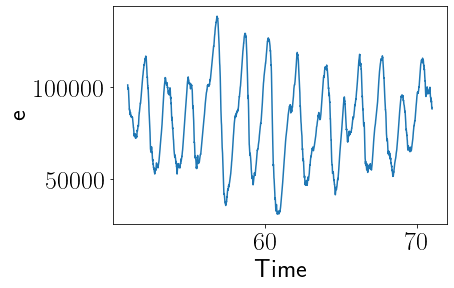

In [18]:
(eta_calc**2).mean(dim = ['xh','yh']).plot()
plt.title('')

# EAPE calculation
$\eta_d'$ used in EAPE calculation is 
$\eta_d' = \eta - \overline{\eta_d}$, 

where $\overline{\eta_d}$ is the time mean of the deviation of inteface height from the sponging interface height
 i.e. $\overline{\eta_d} = \overline{\eta - \eta_0}$
 

In [4]:
def timeseriesEAPE_eta0_relsponging(folder, t1, t2):
    import gc
    ## importing files
    FileList = [folder + 'output' + '{0:03}'.format(i) + '/prog_daily.nc' for i in range(t1 ,t2)]
    dsx_prog_daily = xr.open_mfdataset(FileList, combine='by_coords', chunks={"Time": 20}, decode_times=False, preprocess = lambda d: d[['e', 'h','uh','vh']], engine='netcdf4', parallel=True)
    dsx_prog_daily.coords['Time'] = dsx_prog_daily.coords['Time']/(365)
    import xgcm
    grid = xr.open_mfdataset(folder+'output0*/ocean_geometry.nc', combine='by_coords')
    grid_new = grid.rename({'latq': 'yq','lonq': 'xq','lath': 'yh','lonh': 'xh'})
    ds = xr.merge([dsx_prog_daily.uh, dsx_prog_daily.vh, grid_new])

    ## making grid
    ds.coords['xh'].attrs.update(axis='X')
    ds.coords['xq'].attrs.update(axis='X', c_grid_axis_shift=0.5)
    ds.coords['yh'].attrs.update(axis='Y')
    ds.coords['yq'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

    grid = xgcm.Grid(ds, periodic=['X'])
    grid
    
    
    H  = dsx_prog_daily.e.sel(yh = slice(-50,100)).mean(dim = 'Time')
    eta = (dsx_prog_daily.e.sel(yh = slice(-50,100)) - H)#.isel(zi = slice(1,5))
    rho_layer = [1027.8, 1028.0,1028.1,1028.3]
    g = 9.81
    rho_p = np.asarray([g*(rho_layer[1] - rho_layer[0]),g*(rho_layer[2] - rho_layer[1]), g*(rho_layer[3]-rho_layer[2])])/rho_layer[0]
    APE_cdw = 0.5 * rho_layer[0] * ( rho_p[1] * eta.isel(zi = 2)**2)
    APE_cdw_sum = APE_cdw.sum(dim = 'yh').sum(dim = 'xh')
    print('MAPE loading ..')
    c.run(gc.collect)
    print('saved in ')
    return APE_cdw_sum


In [16]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02/', 51,71)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [ ]:
APE_cdw

Text(0.5, 1.0, '')

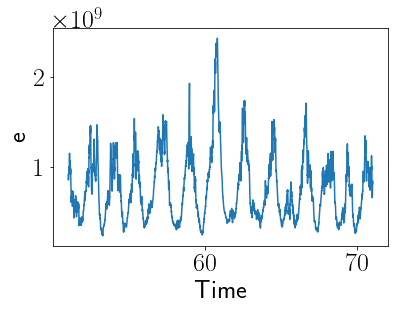

In [17]:
APE_cdw.plot()
plt.title('')

In [18]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag1p5e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag1p5e-03_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [27]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag2p4e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag2p4e-03_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [19]:
 APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag3p6e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag3p6e-03_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [28]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag4p5e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag4p5e-03_EAPE_cdwonly_relsponging.nc')

MAPE loading ..
saved in 


In [20]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag6p0e-03/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_canyonSTEEP_nDSW_sig1p0e+02_cdrag6p0e-03_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [26]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau2p5e-02_sig1p0e+02/', 30,50)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau2p5e-02_sig1p0e+02_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [21]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau5p0e-02_sig1p0e+02/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau5p0e-02_sig1p0e+02_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [24]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau7p5e-03_sig1p0e+02/', 20,40)
APE_cdw.to_netcdf(path='4layer_fresh_tau1p0e-01_newtopo_canyonSILLSTEEP_tau7p5e-02_sig1p0e+02_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 


In [25]:
APE_cdw = timeseriesEAPE_eta0_relsponging('/scratch/v45/qo9901/mom6/archive/4layer_fresh_tau1p2e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02/', 20,40)
APE_cdw.to_netcdf(path= '4layer_fresh_tau1p2e-01_newtopo_canyonSILLSTEEP_nDSW_sig1p0e+02_EAPE_cdwonly_relsponging.nc')


MAPE loading ..
saved in 
